In [1]:
import sys
import subprocess
import numpy as np
import pandas as pd
import scipy.io as sio

import os

from core import *
#from utils import get_lev_dist2nearest
from math import floor
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist, cdist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.cluster import normalized_mutual_info_score

import matplotlib.pyplot as plt
from scipy.sparse import hstack
data_folder='/home/ofir/Bcells/'

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:522: FutureWarning: Passing (type, 1) or 

In [2]:
ms2_data=pd.read_csv(data_folder+'ms2_grouping.csv')

In [3]:
table_j= pd.DataFrame(columns=['table_err_j'])
for i in range (2,6):

    table_j=table_j.append({'table_err_j':data_folder+'Error_J'+str(i)+'.csv'}, ignore_index=True)

In [4]:
table_v= pd.DataFrame(columns=['table_err_v'])
for i in range (2,6):

    table_v=table_v.append({'table_err_v':data_folder+'Error_V'+str(i)+'.csv'}, ignore_index=True)

In [5]:
table_jun= pd.DataFrame(columns=['table_err_jun'])
for i in range (2,6):

    table_jun=table_jun.append({'table_err_jun':data_folder+'table_error_jun_ms'+str(i)+'.csv'}, ignore_index=True)

In [6]:
table_full=pd.read_csv(table_jun.table_err_jun[1])
clone_list=np.unique(table_full.CLONE)
clone_indices=np.where(table_full.CLONE==clone_list[7])[0]
dist2nearest_clone_list=1000*np.ones(clone_indices.shape)
dist2nearest_clone_list_jun=1000*np.ones(clone_indices.shape)

# Compute error distances J

In [7]:
dist2nearest_clone_list=[]
dist2nearest_clone_list_jun=[]
clone_size=[]
sum_non_unique_v=0
sum_non_unique_jun=0
sum_clones_J=0
for dat in range (0,4):
    table_full=pd.read_csv(table_j.table_err_j[dat])
    clone_list=np.unique(table_full.CLONE)
    clone_size=np.append(clone_size,np.unique(table_full.CLONE,return_counts=True)[1])
    if clone_list.shape[0]>1:
        for l in range(0,clone_list.shape[0]):
            temp_res=get_lev_dist2nearest(table_full,clone_list,l)
            dist2nearest_clone_list=np.append(dist2nearest_clone_list,temp_res[0])
            dist2nearest_clone_list_jun=np.append(dist2nearest_clone_list_jun,temp_res[1])
  
            sum_non_unique_jun=sum_non_unique_jun+(temp_res[2]>0)
            sum_clones_J=sum_clones_J+1

In [8]:
bins=np.arange(0, 0.5, 0.01)
group_lists=np.unique(ms2_data.VJ_GROUP)

# Create Background Junction

In [9]:

min_fake_dist_vec=[]
min_fake_dist_vec_jun=[]
for i in range(0,98*2):
    dist2nearest_fake_clone_min=1000
    dist2nearest_jun_fake_clone_min=1000
    clone_size_ind=np.random.randint(0, clone_size.shape[0])
    clone_size_curr=int(clone_size[clone_size_ind])
    clone_group_ind=np.random.randint(0, group_lists.shape[0])
    clone_group_members=np.where(ms2_data.VJ_GROUP==group_lists[clone_group_ind])[0]
    table_group_members=ms2_data.SEQUENCE_INPUT.values[clone_group_members]
    table_group_members_jun=ms2_data.JUNCTION.values[clone_group_members]
    perm_vec1=np.random.permutation(table_group_members.shape[0])
    small_group_members=table_group_members[perm_vec1[:clone_size_curr]]
    small_group_members_jun=table_group_members_jun[perm_vec1[:clone_size_curr]]
    if clone_group_ind!=group_lists.shape[0]-1:
        other_seqs=ms2_data.SEQUENCE_INPUT.values[np.where(ms2_data.VJ_GROUP==group_lists[clone_group_ind+1])[0]]
        other_juns=ms2_data.JUNCTION.values[np.where(ms2_data.VJ_GROUP==group_lists[clone_group_ind+1])[0]]
    else:
        other_seqs=ms2_data.SEQUENCE_INPUT.values[np.where(ms2_data.VJ_GROUP==group_lists[clone_group_ind-1])[0]]
        other_juns=ms2_data.JUNCTION.values[np.where(ms2_data.VJ_GROUP==group_lists[clone_group_ind-1])[0]]
    perm_vec=np.random.permutation(other_seqs.shape[0])
    other_seq=other_seqs[perm_vec][0]
    other_seq_jun=other_juns[perm_vec][0]
    for i in range(0,small_group_members.shape[0]):

            d_ij=sift4(small_group_members[i],other_seq,max_offset=60)
            d_ij=2*(d_ij-np.abs(small_group_members[i].__len__()-other_seq.__len__() ))/(small_group_members[i].__len__()+other_seq.__len__() )
            if d_ij<dist2nearest_fake_clone_min:
                dist2nearest_fake_clone_min=d_ij
            d_ij_jun=sift4(small_group_members_jun[i],other_seq_jun,max_offset=60)
            d_ij_jun=2*(d_ij_jun-np.abs(small_group_members_jun[i].__len__()-other_seq_jun.__len__() ))/(small_group_members_jun[i].__len__()+other_seq_jun.__len__() )
            if d_ij_jun<dist2nearest_jun_fake_clone_min:
                dist2nearest_jun_fake_clone_min=d_ij_jun                                   
    min_fake_dist_vec=np.append(min_fake_dist_vec,dist2nearest_fake_clone_min)
    min_fake_dist_vec_jun=np.append(min_fake_dist_vec_jun,dist2nearest_jun_fake_clone_min)

In [10]:
dist2nearesthistA=np.histogram(dist2nearest_clone_list,bins=bins,density=True)
dist2nearesthistB=np.histogram(min_fake_dist_vec,bins=bins,density=True)

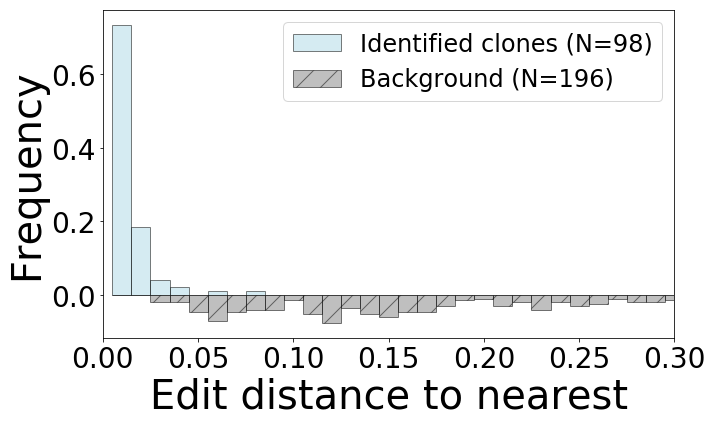

In [11]:
plt.ion()
fig, ax = plt.subplots(figsize=(10,6))
#bins=np.arange(0, 160, 1)
ax.bar(dist2nearesthistA[1][1:],dist2nearesthistA[0]/np.sum(dist2nearesthistA[0]), color='lightblue',ec='k', alpha=0.5,width=0.01,label='Identified clones (N=98)')  # arguments are passed to np.histogram
ax.bar(dist2nearesthistB[1][1:],-dist2nearesthistB[0]/np.sum(dist2nearesthistB[0]), color='grey',ec='k', alpha=0.5,width=0.01,hatch='/',label='Background (N=196)') 
ax.set_xlim([0, 0.3])

#plt.yscale('log')
plt.ylabel('Frequency')
plt.xlabel('Edit distance to nearest')
ax.legend(fontsize=24)
ax.tick_params(labelsize=28)
ax.xaxis.label.set_fontsize(40)
ax.yaxis.label.set_fontsize(40)
plt.tight_layout()


In [12]:
dist2nearesthistA=np.histogram(dist2nearest_clone_list_jun,bins=bins)
dist2nearesthistB=np.histogram(min_fake_dist_vec_jun,bins=bins)

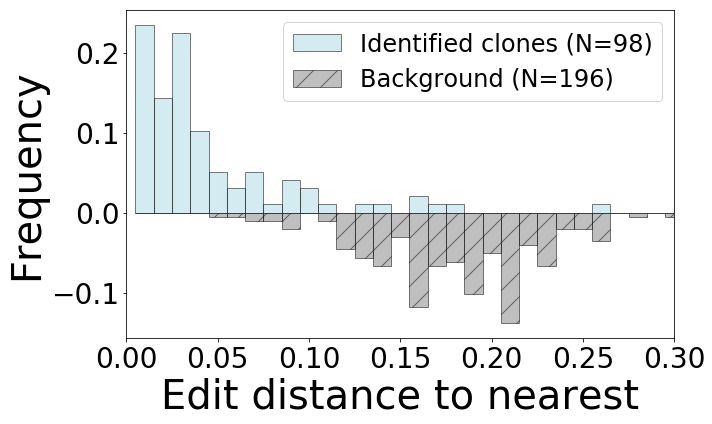

In [13]:
plt.ion()
fig, ax = plt.subplots(figsize=(10,6))
#bins=np.arange(0, 160, 1)
#ax.hist(dist2nearest_clone_list, color='grey',ec='k', bins=bins,alpha=0.5)  # arguments are passed to np.histogram
#ax.hist(dist2nearest_clone_list_jun, color='b',ec='k', bins=bins,alpha=0.5)  # arguments are passed to np.histogram
ax.bar(dist2nearesthistA[1][1:],dist2nearesthistA[0]/np.sum(dist2nearesthistA[0]), color='lightblue',ec='k', alpha=0.5,width=0.01,label='Identified clones (N=98)')  # arguments are passed to np.histogram
ax.bar(dist2nearesthistB[1][1:],-dist2nearesthistB[0]/np.sum(dist2nearesthistB[0]), color='grey',ec='k', alpha=0.5,width=0.01,hatch='/',label='Background (N=196)') 
ax.set_xlim([0, 0.3])
#plt.yscale('log')
plt.ylabel('Frequency')
plt.xlabel('Edit distance to nearest')
ax.tick_params(labelsize=28)
ax.legend(fontsize=24)
ax.xaxis.label.set_fontsize(40)
ax.yaxis.label.set_fontsize(40)
plt.tight_layout()


In [16]:
dist2nearest_clone_list_V=[]
dist2nearest_clone_list_jun_V=[]

clone_size=[]
for dat in range (0,4):
    table_full=pd.read_csv(table_v.table_err_v[dat])
    clone_list=np.unique(table_full.CLONE)

    clone_size=np.append(clone_size,np.unique(table_full.CLONE,return_counts=True)[1])
    if clone_list.shape[0]>1:
        for l in range(0,clone_list.shape[0]):
            temp_res=get_lev_dist2nearest(table_full,clone_list,l)
            dist2nearest_clone_list_V=np.append(dist2nearest_clone_list_V,temp_res[0])
            dist2nearest_clone_list_jun_V=np.append(dist2nearest_clone_list_jun_V,temp_res[1])

            sum_non_unique_jun=sum_non_unique_jun+(temp_res[2]>0)
            sum_clones_J=sum_clones_J+1

In [17]:
dist2nearesthistA=np.histogram(dist2nearest_clone_list_V,bins=bins)
dist2nearesthistB=np.histogram(min_fake_dist_vec[:140],bins=bins)

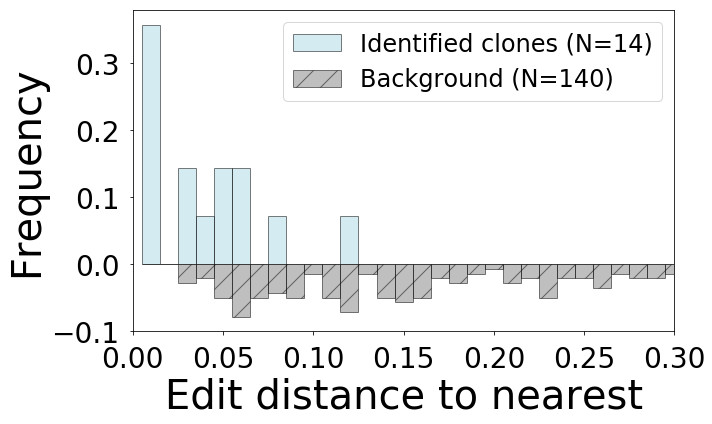

In [18]:
plt.ion()
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(dist2nearesthistA[1][1:],dist2nearesthistA[0]/np.sum(dist2nearesthistA[0]), color='lightblue',ec='k', alpha=0.5,width=0.01,label='Identified clones (N=14)')  # arguments are passed to np.histogram
ax.bar(dist2nearesthistB[1][1:],-dist2nearesthistB[0]/np.sum(dist2nearesthistB[0]), color='grey',ec='k', alpha=0.5,width=0.01,hatch='/',label='Background (N=140)') 
ax.set_xlim([0, 0.3])


plt.ylabel('Frequency')
plt.xlabel('Edit distance to nearest')
ax.tick_params(labelsize=28,pad=10)
ax.xaxis.label.set_fontsize(40)
ax.yaxis.label.set_fontsize(40)
ax.legend(fontsize=24)
plt.tight_layout()


In [19]:
dist2nearesthistA=np.histogram(dist2nearest_clone_list_jun_V,bins=bins)
dist2nearesthistB=np.histogram(min_fake_dist_vec_jun[:140],bins=bins)

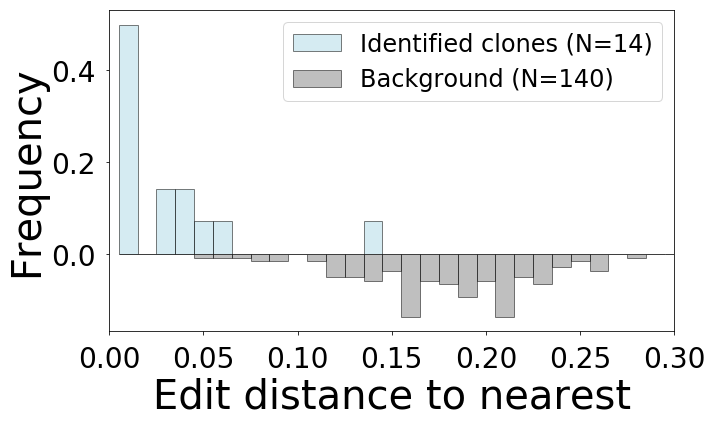

In [20]:
plt.ion()
fig, ax = plt.subplots(figsize=(10,6))

ax.bar(dist2nearesthistA[1][1:],dist2nearesthistA[0]/np.sum(dist2nearesthistA[0]), color='lightblue',ec='k', alpha=0.5,width=0.01,label='Identified clones (N=14)')  # arguments are passed to np.histogram
ax.bar(dist2nearesthistB[1][1:],-dist2nearesthistB[0]/np.sum(dist2nearesthistB[0]), color='grey',ec='k', alpha=0.5,width=0.01,label='Background (N=140)') 
ax.set_xlim([0, 0.3])

plt.ylabel('Frequency')
plt.xlabel('Edit distance to nearest')
ax.tick_params(labelsize=28,pad=10)
ax.xaxis.label.set_fontsize(40)
ax.yaxis.label.set_fontsize(40)
ax.legend(fontsize=24)
plt.tight_layout()


In [21]:
dist2nearest_clone_list_JUN=[]
dist2nearest_clone_list_jun_JUN=[]
sum_non_unique_v_JUN=0
sum_non_unique_j_JUN=0
sum_clones_JUN=0
clone_size=[]
for dat in range (0,4):
    table_full=pd.read_csv(table_jun.table_err_jun[dat])
    clone_list=np.unique(table_full.CLONE)


    clone_size=np.append(clone_size,np.unique(table_full.CLONE,return_counts=True)[1])
    for l in range(0,clone_list.shape[0]):
        clone_indices=np.where(table_full.CLONE==clone_list[l])[0]
        table_full.JUNCTION[clone_indices]
        jun_length_vec=np.zeros(clone_indices.shape[0])
        for s in range (0,clone_indices.shape[0]):
            jun_length_vec[s]=table_full.JUNCTION[clone_indices[s]].__len__()
        jun_length_counts=np.unique(jun_length_vec,return_counts=True)
        distance2_nearest_local_vec=1000*np.ones(jun_length_counts[0].shape[0])
        distance2_nearest_local_vec_jun=1000*np.ones(jun_length_counts[0].shape[0])
        for i in range(0,jun_length_counts[0].shape[0]):

            this_len_vec=np.where(jun_length_vec==jun_length_counts[0][i])[0]
            other_len_vec=np.where(jun_length_vec!=jun_length_counts[0][i])[0]
            for j in this_len_vec:
                for l in other_len_vec:
                    d_jl=sift4(table_full.SEQUENCE_INPUT[clone_indices[j]],table_full.SEQUENCE_INPUT[clone_indices[l]],max_offset=30)
                    d_jl=2*(d_jl-np.abs(table_full.SEQUENCE_INPUT[clone_indices[j]].__len__()-table_full.SEQUENCE_INPUT[clone_indices[l]].__len__() ))/(table_full.SEQUENCE_INPUT[clone_indices[j]].__len__()+table_full.SEQUENCE_INPUT[clone_indices[l]].__len__() )
                    if d_jl<distance2_nearest_local_vec[i]:
                        distance2_nearest_local_vec[i]=d_jl
                    d_jl_jun=sift4(table_full.JUNCTION[clone_indices[j]],table_full.JUNCTION[clone_indices[l]],max_offset=30)
                 
                    d_jl_jun=2*(d_jl_jun-np.abs(table_full.JUNCTION[clone_indices[j]].__len__()-table_full.JUNCTION[clone_indices[l]].__len__() ))/(table_full.JUNCTION[clone_indices[j]].__len__()+table_full.JUNCTION[clone_indices[l]].__len__() )
                    if d_jl_jun<distance2_nearest_local_vec_jun[i]:
                        distance2_nearest_local_vec_jun[i]=d_jl_jun
        dist2nearest_clone_list_JUN=np.append(dist2nearest_clone_list_JUN,distance2_nearest_local_vec)
        dist2nearest_clone_list_jun_JUN=np.append(dist2nearest_clone_list_jun_JUN,distance2_nearest_local_vec_jun)

In [22]:
jun_group_lists=np.unique(ms2_data.JUNCTION_LENGTH)

In [23]:
table_error_jun_fake= pd.DataFrame(columns=['SEQUENCE_ID','CLONE','V_CALL','J_CALL','SEQUENCE_INPUT','SEQUENCE_IMGT','JUNCTION','JUNCTION_LENGTH','GERMLINE_IMGT_D_MASK'])

In [24]:

min_fake_dist_vec=[]
min_fake_dist_vec_jun=[]
for i in range(0,521):
    dist2nearest_fake_clone_min=1000
    dist2nearest_jun_fake_clone_min=1000
    clone_size_ind=np.random.randint(0, clone_size.shape[0])
    clone_size_curr=int(clone_size[clone_size_ind])
    clone_group_ind=np.random.randint(0, jun_group_lists.shape[0])
    clone_group_members=np.where(ms2_data.JUNCTION_LENGTH==jun_group_lists[clone_group_ind])[0]
    table_group_members=ms2_data.SEQUENCE_INPUT.values[clone_group_members]
    table_group_members_jun=ms2_data.JUNCTION.values[clone_group_members]
    perm_vec1=np.random.permutation(table_group_members.shape[0])
    small_group_members=table_group_members[perm_vec1[:clone_size_curr]]
    small_group_members_jun=table_group_members_jun[perm_vec1[:clone_size_curr]]
    clone_group_ind_other=np.random.randint(0, jun_group_lists.shape[0])
    if clone_group_ind_other!=clone_group_ind:
        other_seqs=ms2_data.SEQUENCE_INPUT.values[np.where(ms2_data.JUNCTION_LENGTH==jun_group_lists[clone_group_ind_other])[0]]
        other_juns=ms2_data.JUNCTION.values[np.where(ms2_data.JUNCTION_LENGTH==jun_group_lists[clone_group_ind_other])[0]]

        perm_vec=np.random.permutation(other_seqs.shape[0])
        other_seq=other_seqs[perm_vec][0]
        other_seq_jun=other_juns[perm_vec][0]
        

        table_group_members_all_dat=ms2_data.loc[clone_group_members,:]
        perm_vec2=np.random.permutation(table_group_members_all_dat.index)
        small_group_members_all_dat=table_group_members_all_dat.loc[perm_vec2[:clone_size_curr],:]
        other_seqs=ms2_data.SEQUENCE_INPUT.values[np.where(ms2_data.JUNCTION_LENGTH==jun_group_lists[clone_group_ind_other])[0]]
        other_seqs_all_dat=ms2_data.loc[np.where(ms2_data.JUNCTION_LENGTH==jun_group_lists[clone_group_ind_other])[0],:]
        perm_vec22=np.random.permutation(other_seqs_all_dat.index)
        other_seq_all_dat=other_seqs_all_dat.loc[perm_vec22[0],:]
        for j in small_group_members_all_dat.index:
            table_error_jun_fake=table_error_jun_fake.append({'SEQUENCE_ID':small_group_members_all_dat.SEQUENCE_ID[j],'CLONE':i,'V_CALL':small_group_members_all_dat.V_CALL[j],'J_CALL':small_group_members_all_dat.J_CALL[j],'SEQUENCE_INPUT':small_group_members_all_dat.SEQUENCE_INPUT[j],'SEQUENCE_IMGT':small_group_members_all_dat.SEQUENCE_IMGT[j],'JUNCTION':small_group_members_all_dat.JUNCTION[j],'JUNCTION_LENGTH':small_group_members_all_dat.JUNCTION_LENGTH[j],'GERMLINE_IMGT_D_MASK':small_group_members_all_dat.GERMLINE_IMGT_D_MASK[j]}, ignore_index=True)
        table_error_jun_fake=table_error_jun_fake.append({'SEQUENCE_ID':other_seq_all_dat.SEQUENCE_ID,'CLONE':i,'V_CALL':other_seq_all_dat.V_CALL,'J_CALL':other_seq_all_dat.J_CALL,'SEQUENCE_INPUT':other_seq_all_dat.SEQUENCE_INPUT,'SEQUENCE_IMGT':other_seq_all_dat.SEQUENCE_IMGT,'JUNCTION':other_seq_all_dat.JUNCTION,'JUNCTION_LENGTH':other_seq_all_dat.JUNCTION_LENGTH,'GERMLINE_IMGT_D_MASK':other_seq_all_dat.GERMLINE_IMGT_D_MASK}, ignore_index=True)
        for i in range(0,small_group_members.shape[0]):

                d_ij=sift4(small_group_members[i],other_seq,max_offset=60)
                d_ij=2*(d_ij-np.abs(small_group_members[i].__len__()-other_seq.__len__() ))/(small_group_members[i].__len__()+other_seq.__len__() )
                if d_ij<dist2nearest_fake_clone_min:
                    dist2nearest_fake_clone_min=d_ij
                d_ij_jun=sift4(small_group_members_jun[i],other_seq_jun,max_offset=60)
                d_ij_jun=2*(d_ij_jun-np.abs(small_group_members_jun[i].__len__()-other_seq_jun.__len__() ))/(small_group_members_jun[i].__len__()+other_seq_jun.__len__() )
                if d_ij_jun<dist2nearest_jun_fake_clone_min:
                    dist2nearest_jun_fake_clone_min=d_ij_jun                                   
        min_fake_dist_vec=np.append(min_fake_dist_vec,dist2nearest_fake_clone_min)
        min_fake_dist_vec_jun=np.append(min_fake_dist_vec_jun,dist2nearest_jun_fake_clone_min)

In [25]:
dist2nearesthistA=np.histogram(dist2nearest_clone_list_JUN,bins=bins)
dist2nearesthistB=np.histogram(min_fake_dist_vec,bins=bins)

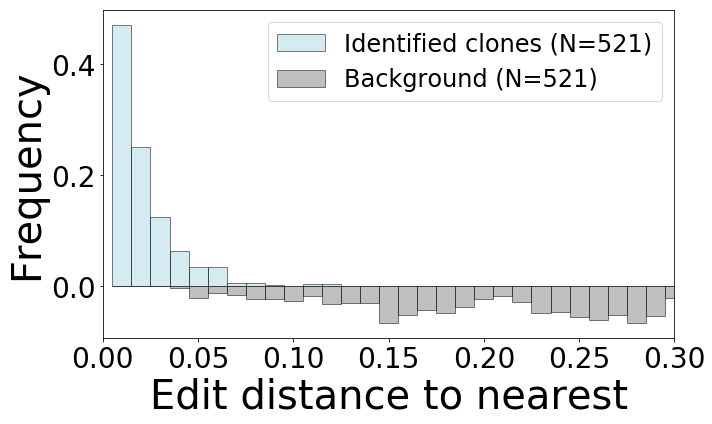

In [26]:
plt.ion()
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(dist2nearesthistA[1][1:],dist2nearesthistA[0]/np.sum(dist2nearesthistA[0]), color='lightblue',ec='k', alpha=0.5,width=0.01,label='Identified clones (N=521)')  # arguments are passed to np.histogram
ax.bar(dist2nearesthistB[1][1:],-dist2nearesthistB[0]/np.sum(dist2nearesthistB[0]), color='grey',ec='k', alpha=0.5,width=0.01,label='Background (N=521)') 
ax.set_xlim([0, 0.3])
#ax.set_xlim([0, 60])
#plt.yscale('log')
plt.ylabel('Frequency')
plt.xlabel('Edit distance to nearest')
ax.tick_params(labelsize=28)
ax.xaxis.label.set_fontsize(40)
ax.yaxis.label.set_fontsize(40)
ax.legend(fontsize=24)
plt.tight_layout()


In [27]:
dist2nearesthistA=np.histogram(dist2nearest_clone_list_jun_JUN,bins=bins)
dist2nearesthistB=np.histogram(min_fake_dist_vec_jun,bins=bins)

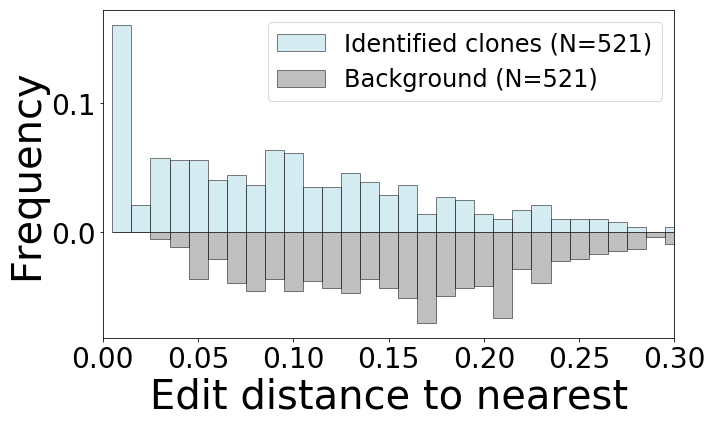

In [28]:
plt.ion()
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(dist2nearesthistA[1][1:],dist2nearesthistA[0]/np.sum(dist2nearesthistA[0]), color='lightblue',ec='k', alpha=0.5,width=0.01,label='Identified clones (N=521)')  # arguments are passed to np.histogram
ax.bar(dist2nearesthistB[1][1:],-dist2nearesthistB[0]/np.sum(dist2nearesthistA[0]), color='grey',ec='k', alpha=0.5,width=0.01,label='Background (N=521)') 
ax.set_xlim([0, 0.3])
#plt.yscale('log')
plt.ylabel('Frequency')
plt.xlabel('Edit distance to nearest')
ax.tick_params(labelsize=28)
ax.xaxis.label.set_fontsize(40)
ax.yaxis.label.set_fontsize(40)
ax.legend(fontsize=24)
plt.tight_layout()


In [29]:
def get_lev_dist2nearest(l):
    clone_indices=np.where(table_full.CLONE==clone_list[l])[0]
    dist2nearest_clone_list=1000*np.ones(clone_indices.shape)
    dist2nearest_clone_list_jun=1000*np.ones(clone_indices.shape)
    sum_non_unique_v=0
    sum_non_unique_jun=0
    t=0
    for i in clone_indices:
        for j in clone_indices:
            if i!=j:
                test1=table_full.J_CALL[i].find(table_full.J_CALL[j][:13])>-1
                test2=table_full.J_CALL[j].find(table_full.J_CALL[i][:13])>-1
                test3=test1|test2
                #if table_full.J_CALL[i]!=table_full.J_CALL[j]:
                if not(test3):
                    d_ij=sift4(table_full.SEQUENCE_INPUT[i],table_full.SEQUENCE_INPUT[j],max_offset=30)
                    if d_ij<dist2nearest_clone_list[t]:
                        dist2nearest_clone_list[t]=d_ij
                    if d_ij<20:
                        d_jun_ij=sift4(table_full.JUNCTION[i],table_full.JUNCTION[j],max_offset=30)
                        if d_jun_ij<dist2nearest_clone_list_jun[t]:
                            dist2nearest_clone_list_jun[t]=d_jun_ij
                        if table_full.V_CALL[i]!=table_full.V_CALL[j]:
                            sum_non_unique_v=sum_non_unique_v+1
                        if table_full.JUNCTION[i].__len__()!=table_full.JUNCTION[j].__len__():
                            sum_non_unique_jun=sum_non_unique_jun+1
                    
        t=t+1
    return dist2nearest_clone_list,dist2nearest_clone_list_jun,sum_non_unique_v,sum_non_unique_jun